# Stock price prediction

[참고 도서]
금융 전략을 위한 머신러닝 (Machine Learning and Data Science Blueprints for Finance) | Hariom Tatsat, Sahil Puri, Brad Lookabaugh 지음 | 김한상 옮김 | 한빛미디어 | 2021년 12월 27일 출간

In this case study we use various supervised learning-based models to predict the stock price of Microsoft using correlated assets and its own historical data.

## 1. Problem definition

Predicted variable: Weekly return of the Microsoft stock

Other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: Microsoft (MSFT), IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX

Following models are implemented:
* Linear Regression
* Lasso
* Elastic Net
* KNN
* Decision Tree (CART)
* Support Vector Machine
* Ada Boost
* Gradient Boosting Method
* Random Forest
* Extra Trees
* Neural Network - Shallow - Using sklearn
* Deep Neural Network - Using Keras

Time series models:
* ARIMA Model
* LSTM - Using Keras



## 2. Load libraries and dataset

In [248]:
# Libraries for data acquisition and visualization
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

# Libraries for supervised regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Libraries for DL models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

# Libraries for time series models
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Disable the warnings
#import warnings
#warnings.filterwarnings('ignore')

In [249]:
# Load data
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [250]:
stk_data.head()

Attributes Adj Close                   Close                    High           \
Symbols         MSFT      IBM   GOOGL   MSFT      IBM   GOOGL   MSFT      IBM   
Date                                                                            
2017-02-21    60.200  136.454  849.27  64.49  172.333  849.27  64.95  172.839   
2017-02-22    60.079  137.127  851.36  64.36  173.184  851.36  64.39  173.365   
2017-02-23    60.322  137.506  851.00  64.62  173.662  851.00  64.73  174.474   
2017-02-24    60.322  137.279  847.81  64.62  173.375  847.81  64.80  173.509   
2017-02-27    59.958  135.803  849.67  64.23  171.511  849.67  64.54  173.279   

Attributes            Low                    Open                      Volume  \
Symbols      GOOGL   MSFT      IBM   GOOGL   MSFT      IBM   GOOGL       MSFT   
Date                                                                            
2017-02-21  852.20  64.45  171.243  846.55  64.61  172.658  847.99  2.066e+07   
2017-02-22  853.79  64.05  172.170  846.71  64.33  172.170  848.00  1.929e+07   
2017-02-23  852.62  64.19  172.964  842.50  64.42  173.996  851.08  2.027e+07   
2017-02-24  848.36  64.14  171.979  842.96  64.53  172.285  847.65  2.180e+07   
2017-02-27  850.67  64.05  171.396  843.01  64.54  173.222  844.95  1.587e+07   

Attributes                        
Symbols           IBM      GOOGL  
Date                              
2017-02-21  4.686e+06  1.260e+06  
2017-02-22  3.159e+06  1.224e+06  
2017-02-23  2.387e+06  1.387e+06  
2017-02-24  3.452e+06  1.346e+06  
2017-02-27  3.861e+06  1.010e+06

In [251]:
ccy_data.head()

,DEXJPUS,DEXUSUK
DATE,,
2017-02-20,NaN,NaN
2017-02-21,113.48,1.246
2017-02-22,113.46,1.246
2017-02-23,112.68,1.255
2017-02-24,112.26,1.250


In [252]:
idx_data.head()

,SP500,DJIA,VIXCLS
DATE,,,
2017-02-20,NaN,NaN,NaN
2017-02-21,2365.38,20743.00,11.57
2017-02-22,2362.82,20775.60,11.74
2017-02-23,2363.81,20810.32,11.71
2017-02-24,2367.34,20821.76,11.47


In [253]:
# 5 business days in a week
return_period = 5

In [254]:
# Y = MSFT future returns
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period) 
Y.name = Y.name[-1]+'_pred'
Y.describe()

count    1255.000
mean        0.006
std         0.032
min        -0.179
25%        -0.011
50%         0.008
75%         0.025
max         0.164
Name: MSFT_pred, dtype: float64

In [256]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)
X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2017-02-20 to 2022-02-18
Freq: B
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GOOGL      1255 non-null   float64
 1   IBM        1255 non-null   float64
 2   DEXJPUS    1188 non-null   float64
 3   DEXUSUK    1188 non-null   float64
 4   SP500      1215 non-null   float64
 5   DJIA       1215 non-null   float64
 6   VIXCLS     1214 non-null   float64
 7   MSFT_DT    1200 non-null   float64
 8   MSFT_3DT   1200 non-null   float64
 9   MSFT_6DT   1200 non-null   float64
 10  MSFT_12DT  1200 non-null   float64
dtypes: float64(11)
memory usage: 122.3 KB


In [257]:
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
dataset.info()
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2017-05-17 to 2022-02-08
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MSFT_pred  225 non-null    float64
 1   GOOGL      225 non-null    float64
 2   IBM        225 non-null    float64
 3   DEXJPUS    225 non-null    float64
 4   DEXUSUK    225 non-null    float64
 5   SP500      225 non-null    float64
 6   DJIA       225 non-null    float64
 7   VIXCLS     225 non-null    float64
 8   MSFT_DT    225 non-null    float64
 9   MSFT_3DT   225 non-null    float64
 10  MSFT_6DT   225 non-null    float64
 11  MSFT_12DT  225 non-null    float64
dtypes: float64(12)
memory usage: 22.9 KB


## 3. Exploratory data analysis
### 3.1 Descriptive statistics

In [258]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000,225.000,225.000,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,0.006,0.004,0.002,1.491e-04,1.707e-04,0.003,0.002,0.002,0.007,0.020,0.039,0.085
std,0.033,0.036,0.039,1.043e-02,1.359e-02,0.027,0.029,0.168,0.032,0.056,0.064,0.073
min,-0.137,-0.131,-0.173,-5.226e-02,-6.616e-02,-0.141,-0.167,-0.442,-0.137,-0.240,-0.299,-0.143
25%,-0.014,-0.017,-0.014,-5.303e-03,-6.979e-03,-0.008,-0.009,-0.103,-0.011,-0.006,0.011,0.042
50%,0.008,0.007,0.003,7.047e-04,-6.658e-04,0.005,0.005,-0.017,0.009,0.022,0.045,0.090
75%,0.026,0.025,0.021,5.920e-03,7.634e-03,0.015,0.016,0.089,0.023,0.048,0.078,0.132
max,0.164,0.096,0.175,5.273e-02,7.540e-02,0.160,0.183,0.651,0.164,0.245,0.207,0.293


In [259]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-05-17,0.019,-0.013,-0.002,-0.023,3.864e-04,-1.791e-02,-0.016,0.423,-0.021,5.425e-04,0.032,0.051
2017-05-24,0.019,0.037,0.010,0.005,-6.955e-04,1.989e-02,0.019,-0.442,0.019,1.218e-03,0.055,0.078
2017-06-01,0.026,0.011,0.001,-0.004,-4.643e-03,6.188e-03,0.003,-0.010,0.019,1.705e-02,0.081,0.091
2017-06-09,-0.005,-0.026,0.013,0.001,-1.155e-02,-2.997e-03,0.003,0.093,-0.020,3.782e-02,0.035,0.088
2017-06-16,0.017,-0.012,0.008,0.002,3.214e-03,5.673e-04,0.005,-0.030,-0.005,5.443e-03,0.023,0.079


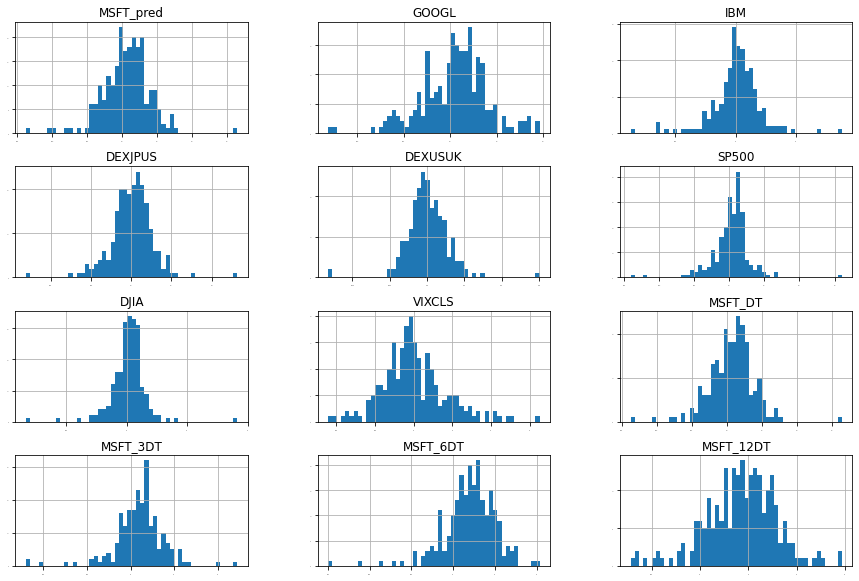

In [260]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(15, 10))
pyplot.show()

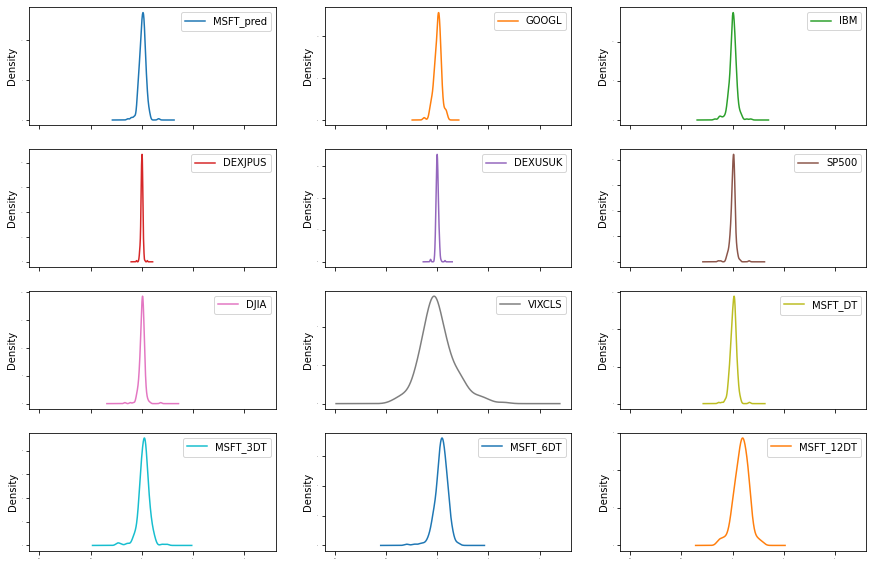

In [261]:
dataset.plot(kind='density', subplots=True, layout=(4, 3), sharex=True, legend=True, fontsize=1, figsize=(15,10))
pyplot.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

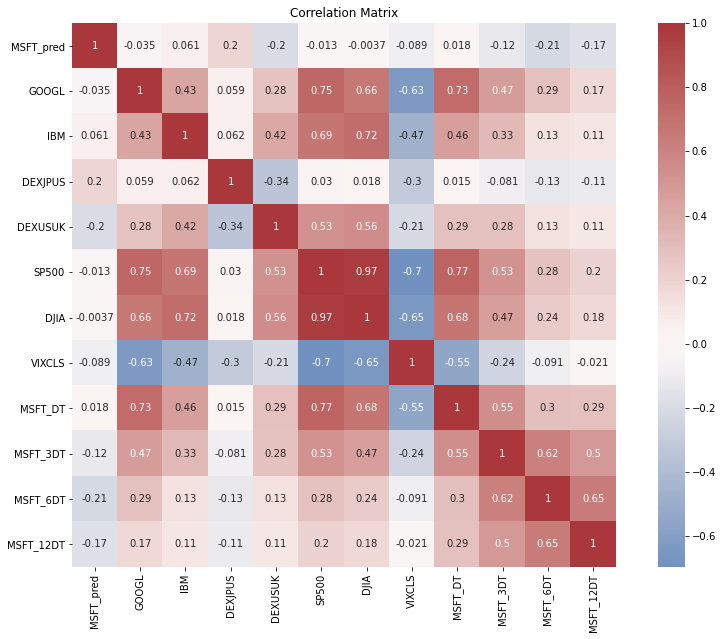

In [262]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,10))
pyplot.title('Correlation Matrix')
#pyplot.xticks(rotation=45)
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='vlag', center=0)

<Figure size 1080x1080 with 0 Axes>

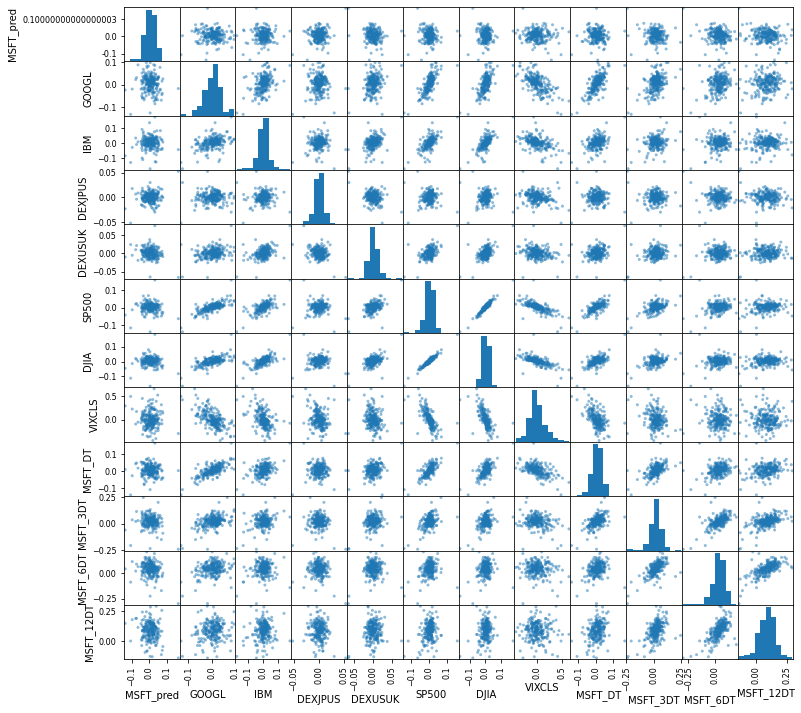

In [263]:
pyplot.figure(figsize=(15,15))
pd.plotting.scatter_matrix(dataset, figsize=(12,12))
pyplot.show()

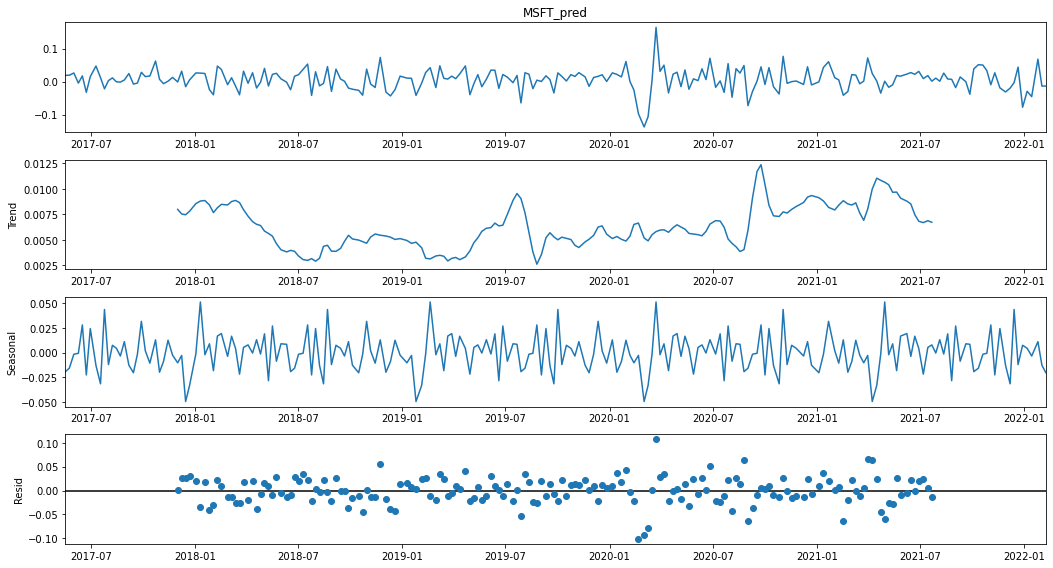

In [264]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can see that for MSFT there has been a general trend upwards. This should show up in our the constant/bias terms in our models

## 4. Data preparation

### 4.1 Feature selection

In [265]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X, Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.nlargest(11,'Score').set_index('Specs')   # Print 11 best features

,Score
Specs,
MSFT_6DT,10.621
DEXJPUS,9.054
DEXUSUK,8.819
MSFT_12DT,6.536
MSFT_3DT,3.452
VIXCLS,1.764
IBM,0.822
GOOGL,0.270
MSFT_DT,0.072


## 5. Evaluate algorithms and models
### 5.1 Train test split and evaluation metrics

In [266]:
validation_size = 0.2

#Select an arbitrary split point in the ordered list of observations and creat two new datasets.
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

### 5.2 Test options and evaluation metrics

In [267]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

### 5.3 Compare models and algorithm
#### 5.3.1 Machine learning models from scikit-learn

In [268]:
# Regression and tree regression algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Neural network algorithm
models.append(('MLP', MLPRegressor()))

# Ensemble models - Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# Ensemble models - Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [269]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    # K fold analysis
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    # Converted mean square error to positive. 
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Full training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001188 (0.000396) 0.000947 0.000975
LASSO: 0.001129 (0.000550) 0.001122 0.000862
EN: 0.001129 (0.000550) 0.001122 0.000862
KNN: 0.001489 (0.000569) 0.000986 0.000935
CART: 0.002643 (0.001188) 0.000000 0.001353
SVR: 0.001320 (0.000784) 0.001049 0.000967
MLP: 0.002289 (0.000774) 0.002930 0.003382
ABR: 0.001315 (0.000573) 0.000593 0.000937
GBR: 0.001530 (0.000514) 0.000096 0.001082
RFR: 0.001378 (0.000626) 0.000187 0.000999
ETR: 0.001401 (0.000598) 0.000000 0.000923


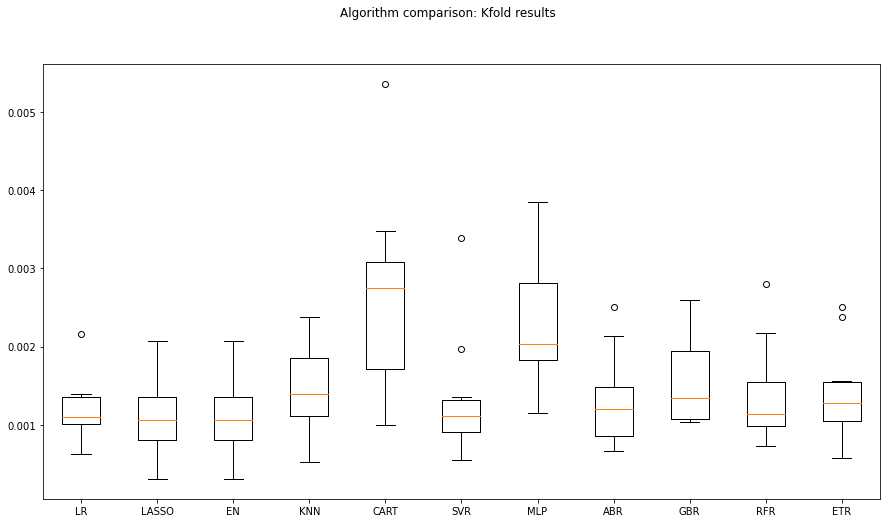

In [270]:
fig = pyplot.figure()
fig.suptitle('Algorithm comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.show()

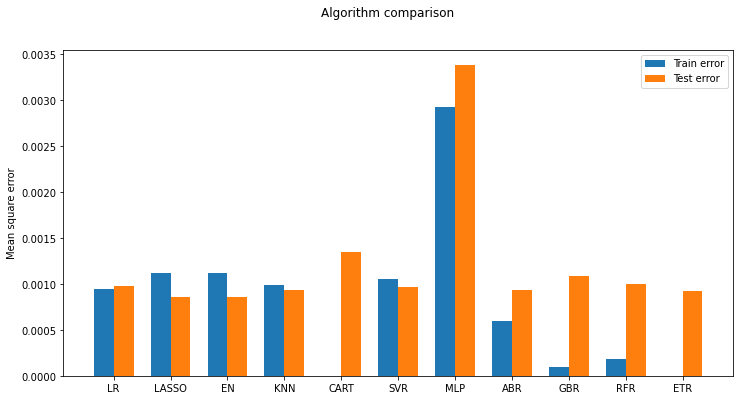

In [271]:
# Compare algorithms
fig  = pyplot.figure()

ind = np.arange(len(names))    #the x locations for the groups
width = 0.35    #the width of the bars

fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test error')
fig.set_size_inches(12, 6)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean square error')
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models. 
Some of the algorithms, such as the decision tree regressor (CART) overfit on the training data and produced very high error on the test set and these models should be avoided. 
Ensemble models, such as gradient boosting regression (GBR) and random forest regression (RFR) have low bias but high variance. 
We also see that the artificial neural network (shown as MLP is the chart) algorithm shows higher errors both in training set and test set, which is perhaps due to the linear relationship of the variables not captured accurately by ANN or improper hyperparameters or insufficient training of the model.

#### 5.3.2 Time series based models - ARIMA and LSTM

ARIMA model

Let us first prepare the dataset for ARIMA models, by having only the correlated varriables as exogenous variables.

In [272]:
X_train_ARIMA = X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA = X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

In [273]:
modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(1,0,0))
model_fit = modelARIMA.fit()

In [274]:
error_training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start=tr_len-1, end=to_len-1, exog=X_test_ARIMA)[1:]
error_test_ARIMA = mean_squared_error(Y_test, predicted) 
error_test_ARIMA

0.000967420896692086

LSTM model

1. 전일의 데이터(모든 특성이 포함된 데이터, 즉 MSFT의 상관 자산과 지연 변수)를 입력으로 취하고, 익일의 값을 예측. 
2. 그다음 하루를 이동해 같은 방식으로 다음 날의 값을 예측. 
3. 전체 데이터셋에 이 과정을 반복.

In [275]:
seq_len = 2     # Length of the sequence for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

LSTM 층에 있는 50개의 은닉 유닛을 통과해 주식 수익값으로 반환.

In [276]:
# LSTM network
def create_LSTMmodel(neurons=12, learn_rate=0.01, momentum=0):
    # Create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    # More number of cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model

LSTMmodel = create_LSTMmodel(12, learn_rate=0.01, momentum=0)
LSTMmodel_fit = LSTMmodel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM), epochs=330, batch_size=27, verbose=0, shuffle=False)

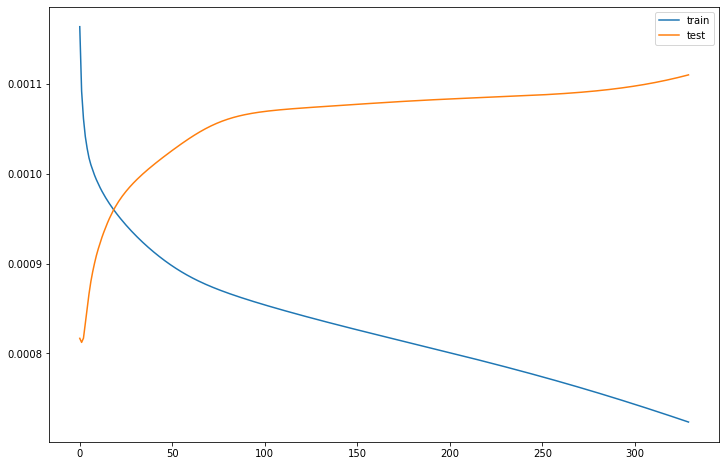

In [277]:
# Visual plot to check if the error is reducing
pyplot.plot(LSTMmodel_fit.history['loss'], label='train')
pyplot.plot(LSTMmodel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [278]:
error_training_LSTM = mean_squared_error(Y_train_LSTM, LSTMmodel.predict(X_train_LSTM))
predicted = LSTMmodel.predict(X_test_LSTM)
error_test_LSTM = mean_squared_error(Y_test, predicted)

In [279]:
# Append to previous results
test_results.append(error_test_ARIMA)
test_results.append(error_test_LSTM)

train_results.append(error_training_ARIMA)
train_results.append(error_training_LSTM)

names.append("ARIMA")
names.append("LSTM")

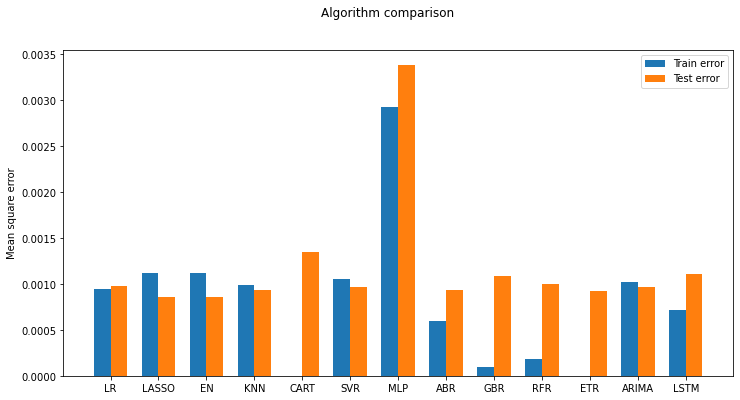

In [280]:
# Compare algorithms
fig  = pyplot.figure()

ind = np.arange(len(names))    #the x locations for the groups
width = 0.35    #the width of the bars

fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test error')
fig.set_size_inches(12, 6)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean square error')
pyplot.show()

Looking at the chart above, we find time series based ARIMA model comparable to the linear supervised-regression models such as LR, LASSO and EN. 
This can primarily be due to the strong linear relationship as discussed before. 
The LSTM model performs decently, however, ARIMA model outperforms the LSTM model in the test set. 
Hence, we select the ARIMA model for the model tuning.

## 6. Model tuning and grid search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. 
The default order of ARIMA model is (1,0,0). 
We perform a grid search with different combination p,d and q in the ARIMA model's order.

In [281]:
# Grid search for ARIMA model
# Change p, d and q and check for the best result

# Evaluate an ARIMA model for a given order (p,d,q)
# Assuming that the train and test data is already defined before
def evaluate_arima_model(arima_order):
    modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_vlaues, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_vlaues:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# Evaluate parameters
p_vlaues = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
evaluate_models(p_vlaues, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0010347
ARIMA(0, 0, 1) MSE=0.0010256
ARIMA(0, 1, 0) MSE=0.0016101
ARIMA(0, 1, 1) MSE=0.0010671
ARIMA(1, 0, 0) MSE=0.0010262
ARIMA(1, 0, 1) MSE=0.0010254
ARIMA(1, 1, 0) MSE=0.0015039
ARIMA(1, 1, 1) MSE=0.0010699
ARIMA(2, 0, 0) MSE=0.0010242
ARIMA(2, 0, 1) MSE=0.0010255
ARIMA(2, 1, 0) MSE=0.0014194
ARIMA(2, 1, 1) MSE=0.0010559
Best ARIMA(2, 0, 0) MSE=0.0010242


## 7. Finalise the model
### 7.1 Results on the test dataset

In [282]:
# Prepare model
modelARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(2,0,0))
model_fit_tuned = modelARIMA_tuned.fit()

In [283]:
# Estimate accuracy on validation set
predicted_tuned = model_fit.predict(start=tr_len-1, end=to_len-1, exog=X_test_ARIMA)[1:]
print(mean_squared_error(Y_test, predicted_tuned))

0.000967420896692086


### 7.2 Save model for later use

In [284]:
#Libraries for Saving the Model
from pickle import dump

filename = 'finalised_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

In [285]:
# # some time later...
# # load the model from disk
# from pickle import load
# loaded_model = load(open(filename, 'rb'))
# # estimate accuracy on validation set
# #rescaledValidationX = scaler.transform(X_validation) #in case the data is scaled.
# #predictions = model.predict(rescaledValidationX)
# predictions = model.predict(X_validation)
# result = mean_squared_error(Y_validation, predictions)
# print(result)

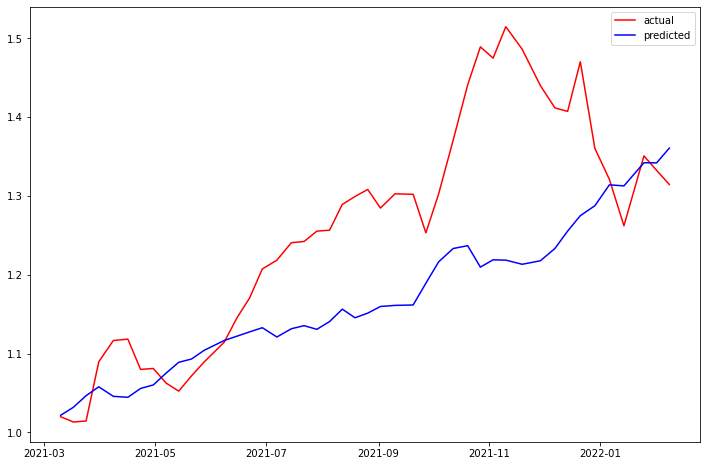

In [286]:
# Comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r', label='actual') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b', label='predicted')
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (12,8)
pyplot.show()

Summary

We can conclude that simple models - linear regression, regularized regression (i.e. Lasso and elastic net) - along with the time series model such as ARIMA are promis‐ ing modelling approaches for asset price prediction problem. These models can enable financial practitioners to model time dependencies with a very flexible approach. The overall approach presented in this case study may help us encounter overfitting and underfitting which are some of the key challenges in the prediction problem in finance. We should also note that we can use better set of indicators, such as P/E ratio, trading volume, technical indicators or news data, which might lead to better results. We will demonstrate this in some of the case studies in the book. Overall, we created a supervised-regression and time series modelling framework which allows us to perform asset class prediction using historical data to generate results and analyze risk and profitability before risking any actual capital.